In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import os

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage import io
import copy
import gc
from sklearn.svm import LinearSVC
from joblib import dump

In [73]:
class CelebA_Dataset(Dataset):
    def __init__(self, data_dir, split, transform):
        super().__init__()
        self.img_dir = os.path.join(data_dir + "/img_align_celeba")
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        self.make_split()
    
    def make_split(self):
        partition_list_path = os.path.join(self.data_dir, "list_eval_partition.txt")
        partition_list = np.loadtxt(partition_list_path, dtype=str)
        if self.split == "train":
            self.img_names = partition_list[partition_list[:, 1].astype(float) == 0, 0]
        elif self.split == "test":
            self.img_names = partition_list[partition_list[:, 1].astype(float) > 0, 0]
            
    def t(self, img):
        return self.transform(img)
        
    def __len__(self):
        return len(self.img_names)
    
    def t(self, img):
        return self.transform(img)
        
    def __getitem__(self, idx):
        file_name = os.path.join(self.img_dir, self.img_names[idx])
        img = np.array(Image.open(file_name))
        
        if self.transform:
            img = self.t(img)
    
        return img

In [88]:
t = transforms.Compose([transforms.ToTensor(),
                        transforms.Resize((128, 128)),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                       ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((128, 128))
#                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])

In [89]:
train_dataset = CelebA_Dataset("./data", "train", t)
test_dataset = CelebA_Dataset("./data", "test", test_transform)

In [96]:
def visual(img_to_display=4):
    print("Displaying images in the dataset")
    fig, ax = plt.subplots(1, img_to_display)
    fig.set_size_inches(25, 8)
    
    for id in range(img_to_display):
        ax[id].imshow(test_dataset[id].permute(1,2,0))
        ax[id].axis("off")
    plt.tight_layout()
    plt.show()

Displaying images in the dataset


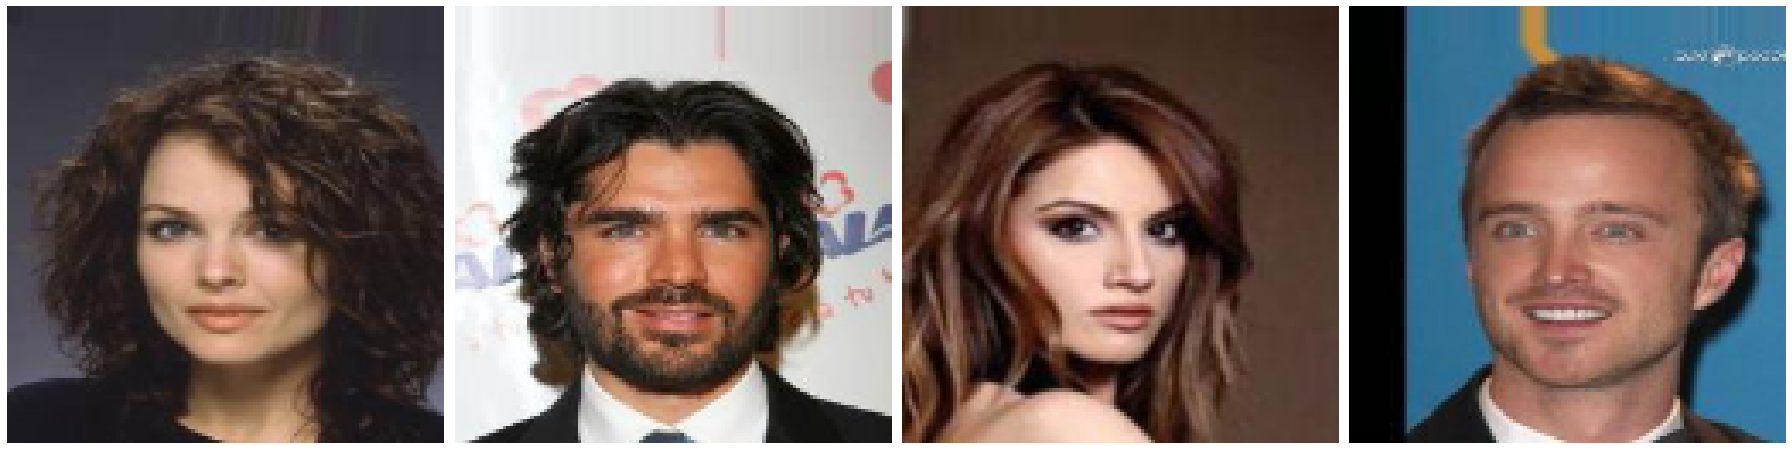

In [98]:
visual()

In [ ]:
class ConvVAE(nn.Module):
    